# Hand-written digits classifier with tensorflow 

This notebook is my personal tutorial for building a hand-written image classifier with tensorflow. It is based both on tensorflow's tutorial on convolutional neural networks (CNN) as well as on various blogs and experimentation (see 'sources' section). 

I am using the MNIST database (https://en.wikipedia.org/wiki/MNIST_database) running first a two-layer dense neural network (with some tuning) and subsequently a three-layer CNN. A more complex CNN would outperform this setup, however, the training is run with limited compute power on a local machine.  

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# set style for seaborn charts 
sns.set_style("whitegrid")
%matplotlib inline

## Import data

In [3]:
# import database 
from tensorflow.examples.tutorials.mnist import input_data

# The 'read_data_sets' property downloads the data during the first execution -
# and acceses it locally thereafter
DATASET = input_data.read_data_sets('data\\MNIST')

# extract training and evaluation sets as numpy arrays 
train_data = DATASET.train.images  
train_labels = np.asarray(DATASET.train.labels, dtype=np.int32)
eval_data = DATASET.test.images  
eval_labels = np.asarray(DATASET.test.labels, dtype=np.int32)

# reduce verbose output
tf.logging.set_verbosity(tf.logging.WARN)

Extracting data\MNIST\train-images-idx3-ubyte.gz
Extracting data\MNIST\train-labels-idx1-ubyte.gz
Extracting data\MNIST\t10k-images-idx3-ubyte.gz
Extracting data\MNIST\t10k-labels-idx1-ubyte.gz


## A look at the data

In [4]:
# Looking at the input shapes 
print(train_data.shape)
print(eval_data.shape)
print(train_labels.shape)
print(eval_labels.shape)

(55000, 784)
(10000, 784)
(55000,)
(10000,)


There are **55,000 greyscale images in the training data and 10,000 in the evaluation set.** Each image has 28x28 pixels, which are flattened into the second dimension of the array as **784** floating point values. The labels are encoded in one dimension as integers beteween 0-9 (i.e., not one-hot-encoded)

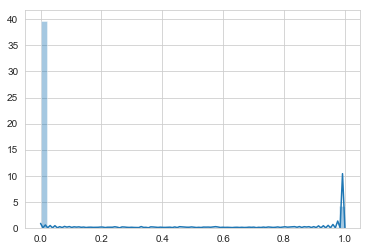

In [12]:
# looking at the dstribution of the pixel values of the combined first 20 images
sns.distplot(np.ndarray.flatten(train_data[0:20, :]))

Pixels may each take a **value between 0-1.** We see that most pixels are black (i.e., pixel value of 0) 

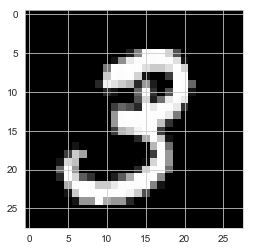

The label is: 3


In [18]:
# Looking at a sample image 
index = 1 
image = train_data[index]
# reshape to 28x28 pixels 
image = image.reshape([28, 28])
plt.imshow(image, cmap='gray')
plt.show()
print("The label is:", str(train_labels[index]))

## Prepare model input functions

A few notes on the input functions: 

- Be careful to **deactivate shuffle for evaluation** 
- Make sure that **num_epochs == 0 for training.** This lets the model run until it has gone through the number of steps specified in the training function (and not stop once it has run through 1 epoch, which is the default when not specified)
- Make sure the name of the input feature ('x' here) matches the name of the input feature in the dictionary <x = dict({'x': features})>

In [22]:
# PREPARE MODEL INPUT

# create feature column of the shape (784, None) 
def flat_features():
    return [tf.contrib.layers.real_valued_column("x", dimension=train_data.shape[1])]
 
# create input function.  
def make_input_fn(features, labels, num_epochs, shuffle_state=False):
    """
    features -- numpy array of featurs of the shape (samples, features)
    labels -- numpy array of labels of the shape (labels,)
    num_empochs -- set to 0 for training and 1 for evaluation and predicting 
    shuffle_state -- set to True for training 
    """
    return tf.estimator.inputs.numpy_input_fn(
        x = dict({'x': features}),
        y = labels,
        batch_size = 128,
        num_epochs = num_epochs,
        shuffle = shuffle_state,
        queue_capacity = 1000,
        num_threads = 1,    
    )    

## Define train and evaluate function for fully connected DNN

In [21]:
def dnn_train_and_evaluate(output_dir, num_train_steps, learning_rate, batch_norm, dropout):
    """
    Arguments: 
        output_dir -- directory to save log files during training 
        num_train_steps -- number of steps (i.e, batches) to train for 
        learning_rate -- learning rate 
        batch_norm -- set to True to apply batch normalization for each hidden layer 
        dropout -- choose dropout rate for hidden layers
    Returns:
        model instance 
    """
    # Specify output directory  
    run_config = tf.estimator.RunConfig(
                 model_dir=output_dir,      
                 save_summary_steps=100,                       
                 save_checkpoints_steps=100 # dictates max frequency of evaluations during training
                )    
    
    # set optimization hyperparameters 
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # specify model 
    estimator = tf.estimator.DNNClassifier(hidden_units=[128, 32],
                                           n_classes=10,
                                           config=run_config,
                                           feature_columns = flat_features(),
                                           optimizer = optimizer,
                                           activation_fn=tf.nn.relu,
                                           dropout=dropout,
                                           batch_norm=batch_norm)
         
    # specify train set
    train_spec = tf.estimator.TrainSpec(input_fn = make_input_fn(train_data, 
                                                                 train_labels, 
                                                                 shuffle_state=True,
                                                                 num_epochs=None), 
                                        max_steps = num_train_steps)
    
    # specify eval set 
    eval_spec = tf.estimator.EvalSpec(input_fn = make_input_fn(eval_data, 
                                                               eval_labels,
                                                               shuffle_state=False,
                                                               num_epochs=1), 
                                        steps = None, 
                                        throttle_secs = 5)  # evaluates no more than every 5 seconds
    
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
    return estimator

## Run baseline model 

In [36]:
# run baseline model
baseline_model = dnn_train_and_evaluate(output_dir='CHECKPOINTS/MNIST_model/baseline1', 
                                   num_train_steps = 10000, 
                                   learning_rate = 0.01, 
                                   batch_norm = False, 
                                   dropout = 0
                                  )

### Calculate final accuracy on the train and evaluation sets

In [37]:
# calculate final accuracy on train and evaluation sets 
def show_accuracy(model): 
    eval_accuracy = model.evaluate(input_fn = make_input_fn(eval_data, eval_labels, 
                                                                 shuffle_state=False,
                                                                 num_epochs=1
                                                                ))['accuracy']
    train_accuracy = model.evaluate(input_fn = make_input_fn(train_data, train_labels, 
                                                                 shuffle_state=False,
                                                                 num_epochs=1
                                                                ))['accuracy']

    print("evaluation accuracy:", str(100*eval_accuracy))
    print("training accuracy:", str(100*train_accuracy))

After 10,000 iterations, the baseline model shows an accuracy of 97,12% on the evaluation set 

In [38]:
show_accuracy(baseline_model)

evaluation accuracy: 97.11999893188477
training accuracy: 99.12182092666626


### Show a sample and the overall number of incorrect predictions 

In [31]:
# show incorrect predictions in the evaluation dataset 
def show_incorrect_predictions(model): 
    # the predict method returns an iterator object from which we have to extract the class prediction
    predictions = list(model.predict(input_fn = make_input_fn(eval_data, eval_labels,
                                                                 shuffle_state=False,
                                                                 num_epochs=1)))
    predicted_classes = [p['class_ids'] for p in predictions]
    
    # get all labels and subtract them from predicted labels 
    predicted_classes = np.reshape(np.array(predicted_classes), (10000,))
    delta_array = predicted_classes - eval_labels
    
    # find index of wrongly classified images 
    error_index = np.nonzero(delta_array)[0]
    
    # choose random mis-classified images 
    error_sample = np.random.choice(error_index, 3)

    # print mis_classified images 
    for i in error_sample: 
        print("Prediction:", str(predicted_classes[i]))
        print("Label:", str(eval_labels[i]))
        image = eval_data[i]
        image = image.reshape([28, 28]);
        plt.imshow(image, cmap='gray')
        plt.show()
   
    return len(error_index)
    

Prediction: 6
Label: 4


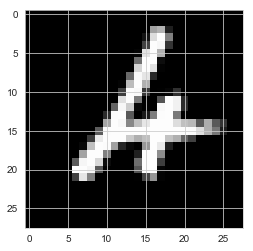

Prediction: 2
Label: 3


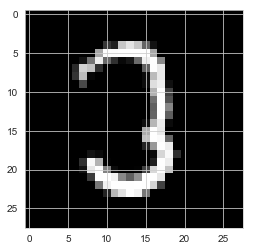

Prediction: 7
Label: 2


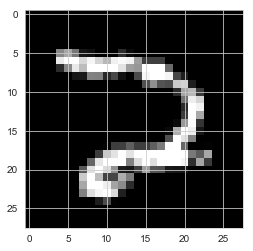

In [39]:
num_errors = show_incorrect_predictions(baseline_model)

#### The baseline model misclassified 288 images overall

In [40]:
print(num_errors)

288


## Batchnorm and dropout model 

From the average loss during training we can see that the previous model started overfitting on the training data, i.e., the loss on the evaluation set starting to get worse again. The next model will thus include dropout regularization to address this. It will also run with batch normalization to prevent the ReLU neurons from "dying"  

<img src='images\MNIST_01.PNG' width='600' height='600'/>

In [41]:
# run model with batch normalization and dropout regularization 
batchnorm_model = dnn_train_and_evaluate(output_dir='CHECKPOINTS/MNIST_model/model1', 
                                   num_train_steps = 10000, 
                                   learning_rate = 0.01, 
                                   batch_norm = True, 
                                   dropout = 0.08
                                  )

The second model slightly impoves on the eval set accuracy against the baseline model:
- Baseline model: 97.12%
- Batchnorm model: 97.59%

In [45]:
show_accuracy(batchnorm_model)

evaluation accuracy: 97.58999943733215
training accuracy: 99.29090738296509


Prediction: 3
Label: 7


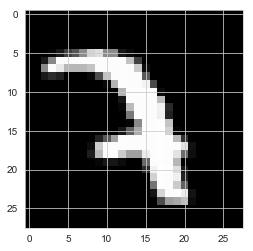

Prediction: 7
Label: 2


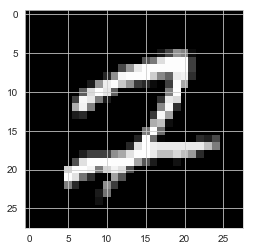

Prediction: 6
Label: 4


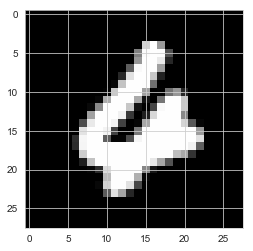

In [46]:
num_errors = show_incorrect_predictions(batchnorm_model)

The total number of errors has increased relative to the baseline model:
- Baseline model: 288
- Batchnorm model: 241 

In [47]:
print(num_errors)

241


We can see the effect of the normalization when comparing the average losses of the two models. While the training losses (in red and burgundy) are quite similar, eval set loss of the second model (in green) stabilizes rather than getting worse again as training goes on:

<img src='images\MNIST_02.PNG' width='600' height='600'/>

## Convolutional neural network 

We can keep the input serving function from the previous model and will define a two-layer CNN (as is done in the tensorflow tutorial) which will be integrated into a train_and_evaluate function. 

Here is the CNN configuration: 

- Convolutional Layer #1: Applies 32 5x5 filters, with ReLU activation function
- Pooling Layer #1: Performs max pooling with a 2x2 filter and stride of 2 
- Convolutional Layer #2: Applies 64 5x5 filters, with ReLU activation function
- Pooling Layer #2: Performs max pooling with a 2x2 filter and stride of 2
- Pooling Layer #2: Performs max pooling with a 2x2 filter and stride of 2
- Dense Layer #1: 1,024 neurons, with dropout regularization rate of 0.4 (probability of 0.4 that any given element will be dropped during training)
- Dense Layer #2 (Logits Layer): 10 neurons, one for each digit target class (0–9).

Below is the graph representation from tensorboard:

<img src='images\CNN_MNIST.PNG' width='400' height='400'/>

### Writing the model function

In [49]:
# create the CNN function 
def cnn_model_fn(features, labels, mode):
    """
    features, labels -- as returned from the input function 
    mode -- from tf.estimator.ModeKeys: TRAIN, EVAL, PREDICT
    
    """
    # Input Layer: using -1 as input leads the function to infer this dimension based on the input 
    # i.e., the number of samples. The input will have the sahpe (samples, 28, 28, channels)
    input_layer = tf.reshape(features['x'], [-1, 28, 28, 1])

    # Convolutional Layer #1
    # 'Same' padding adds two zero rows and columns to the input to make sure output is (-1, 28, 28, 32) 
    conv1 = tf.layers.conv2d(inputs=input_layer,
                             filters=32,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)

    # Pooling Layer #1 -- reduces the size to (-1, 14, 14, 32)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2
    # Transforms the (-1, 14, 14, 32) input into a (-1, 14, 14, 64) output
    conv2 = tf.layers.conv2d(inputs=pool1,
                             filters=64,
                             kernel_size=[5, 5],
                             padding="same",
                             activation=tf.nn.relu)

    # Pooling Layer #2
    # Transforms the (-1, 14, 14, 64) input into a (-1, 7, 7, 64) output
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

    # Dense Layer -- transforms the input into one column vector output and passes it through a dense layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    # checks if mode is TRAIN and applies dropout (otherwise not)
    dropout = tf.layers.dropout(inputs=dense, 
                                rate=0.4, 
                                training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer (output layer) -- outputs shape of (samples, features)
    logits = tf.layers.dense(inputs=dropout, units=10)
        
    # create dictionaries of classes and probabilities going row by row through input 
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode). 
        # tf.argmax returns index of largest values along feature axis (i.e., number 0-9)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    # tf.estimator.EstimatorSpec creates an iterable where the output and input depends 
    # on the mode (TRAIN, EVAL, PREDICT)
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,
                                      global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
          "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Writing the new train and evaluate function 

In [51]:
# create the train and evaluate function
def cnn_train_and_evaluate(output_dir, num_train_steps):
    
    # Specify output directory  
    run_config = tf.estimator.RunConfig(
                 model_dir=output_dir,      
                 save_summary_steps=50,                       
                 save_checkpoints_steps=50)   # dictates max frequency of eval
    
    
    # specify model 
    estimator = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=output_dir,
                                      config = run_config)
         
    # specify train set
    train_spec = tf.estimator.TrainSpec(input_fn = make_input_fn(train_data, 
                                                                 train_labels, 
                                                                 shuffle_state=True,
                                                                 num_epochs=None), 
                                        max_steps = num_train_steps)
    
    # specify eval set 
    eval_spec = tf.estimator.EvalSpec(input_fn = make_input_fn(eval_data, 
                                                               eval_labels,
                                                               shuffle_state=False,
                                                               num_epochs=1), 
                                        steps = None, 
                                        throttle_secs = 5)  # evaluates no more than every 5 seconds
    
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)
    
    return estimator

## Run CNN model

In [55]:
cnn_model = cnn_train_and_evaluate(output_dir='CHECKPOINTS/MNIST_model/cnn', 
                                       num_train_steps = 10000)   

After **10,000 steps**, the evaluation set accuracy has reached 95.31%. Interestingly, at this stage this is higher than the accuracy on the training set at 94.97%, though I would expect this to be driven by chance and potentially the eval set to be slightly easier than the train set. 



In [56]:
show_accuracy(cnn_model)

evaluation accuracy: 95.31000256538391
training accuracy: 94.98181939125061


Looking at the **tensorboard output**, we can see that the accuracy is still steadily improving at this point and could likely close the gap with the previous two models if given the time and compute resources.

(orange == CNN model eval set accuracy, green line == DNN model eval set accuracy) 


<img src='images\CNN_train.PNG' width='600' height='600'/>

### Looking at the errors

Prediction: 2
Label: 7


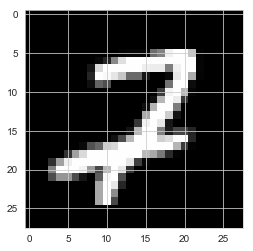

Prediction: 1
Label: 6


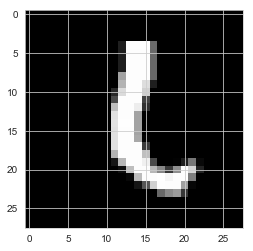

Prediction: 8
Label: 9


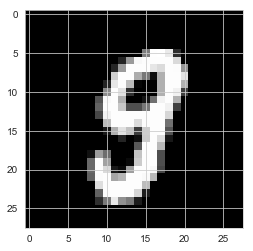

In [61]:
predictions = list(cnn_model.predict(input_fn = make_input_fn(eval_data, eval_labels,
                                                                 shuffle_state=False,
                                                                 num_epochs=1)))
predicted_classes = [p['classes'] for p in predictions]
    
# get all labels and subtract them from predicted labels 
predicted_classes = np.reshape(np.array(predicted_classes), (10000,))
delta_array = predicted_classes - eval_labels
    
# find index of wrongly classified images 
error_index = np.nonzero(delta_array)[0]
    
# choose random mis-classified images 
error_sample = np.random.choice(error_index, 3)

# print mis_classified images 
for i in error_sample: 
    print("Prediction:", str(predicted_classes[i]))
    print("Label:", str(eval_labels[i]))
    image = eval_data[i]
    image = image.reshape([28, 28]);
    plt.imshow(image, cmap='gray')
    plt.show()

In [62]:
print(len(error_index))

469


### Sources
- https://www.tensorflow.org/tutorials/estimators/cnn
- https://sefiks.com/2017/09/11/handwritten-digit-classification-with-tensorflow